#DJIA 30 Stock Time Series dataset
The script used to acquire all of the following data can be found in this GitHub repository. This repository also contains the modeling codes and will be updated continually, so welcome starring or watching!

Stock market data can be interesting to analyze and as a further incentive, strong predictive models can have large financial payoff. The amount of financial data on the web is seemingly endless. A large and well structured dataset on a wide array of companies can be hard to come by. Here provided a dataset with historical stock prices (last 12 years) for 29 of 30 DJIA companies (excluding 'V' because it does not have the whole 12 years data).

      ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GE',

      'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE',

      'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'GOOGL', 'AMZN', 'AABA']

####Content
The data is presented in a couple of formats to suit different individual's needs or computational limitations.
I have included files containing 13 years of stock data (in the all_stocks_2006-01-01_to_2018-01-01.csv and corresponding folder) and
a smaller version of the dataset (all_stocks_2017-01-01_to_2018-01-01.csv) with only the past year's stock data for those wishing to use something more manageable in size.

The folder individual_stocks_2006-01-01_to_2018-01-01 contains files of data for individual stocks, labelled by their stock ticker name.
The all_stocks_2006-01-01_to_2018-01-01.csv and all_stocks_2017-01-01_to_2018-01-01.csv contain this same data, presented in merged .csv files.
Depending on the intended use (graphing, modelling etc.) the user may prefer one of these given formats.

All the files have the following columns:
Date - in format: yy-mm-dd

Open - price of the stock at market open (this is NYSE data so all in USD)

High - Highest price reached in the day

Low Close - Lowest price reached in the day

Volume - Number of shares traded

Name - the stock's ticker name

In [23]:
# Importing the libraries
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [24]:
# Let's get the data. I will be using IBM stock prices for this
#dataset = pd.read_csv('./DJIA_30_Stock_Time_Series/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date']) # IBM
dataset = pd.read_csv('./DJIA_30_Stock_Time_Series/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date']) # AAPL
brand = dataset['Name'][0]
dataset.head(2)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL


In [25]:
# Checking for missing values on 'Date' and 'Close'
dataset.iloc[:0,4].isna().sum()

0

In [26]:
# We have chosen 'Close' attribute for prices. Selecting Training and Validation/Testing data
train = dataset["Close"][:"2015"]
val   = dataset["Close"]["2016":]
print(f'Total length: {len(train) + len(val)}; Train Dataset length until 2015-12-31: {len(train)} Test Dataset length from 2016-01-01: {len(val)}')

Total length: 3019; Train Dataset length until 2015-12-31: 2516 Test Dataset length from 2016-01-01: 503


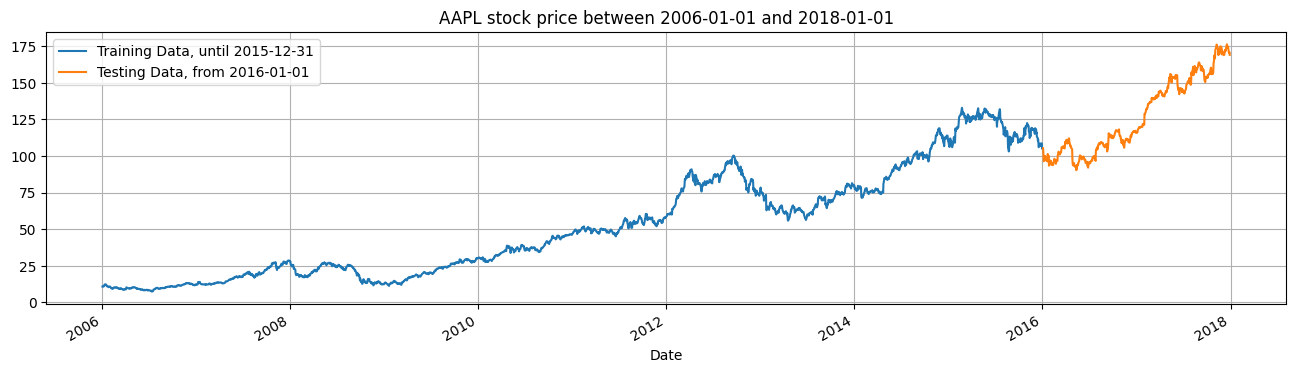

In [27]:
# Let's plot see what it looks like
train.plot(figsize=(16,4),legend=True)
val.plot(figsize=(16,4),legend=True)
plt.legend(['Training Data, until 2015-12-31','Testing Data, from 2016-01-01'])
plt.title(f'{brand} stock price between 2006-01-01 and 2018-01-01')
plt.grid('major')
plt.show()

In [28]:
# Scaling the Close values
sc = MinMaxScaler(feature_range=(0,1))
train_data = sc.fit_transform(train.copy().values.reshape(-1,1))
val_data   = sc.fit_transform(val.copy().values.reshape(-1,1))

In [29]:
# Create a funtion to generate features and labels datasets
def create_XY(data, block_size):
    X, Y = [], []
    for i in range(block_size, len(data)):
        X.append(data[i-block_size:i ,0].reshape(-1, 1))
        Y.append(data[i, 0].reshape(-1, 1))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [30]:
# Since LSTMs store long term memory state, we create a data structure with 20 timesteps and 1 output
# So for each element of training set, we have 20 previous training set elements
block_size = 15
Xtr, Ytr = create_XY(train_data, block_size)
Xte, Yte = create_XY(val_data, block_size)

In [31]:
# Let's check the shape for all tensors
Xtr.shape, Ytr.shape, Xte.shape, Yte.shape

(torch.Size([2501, 15, 1]),
 torch.Size([2501, 1, 1]),
 torch.Size([488, 15, 1]),
 torch.Size([488, 1, 1]))

In [32]:
# Set Hyperparameters
seq_length  = block_size
batch_size  = 0

input_size  = 1
hidden_size = 32 
num_layers  = 1 # 1 gives better convergence on loss with less rmse compair to 2
num_classes = 1

device      = 'cpu'
max_steps   = 2000 # epochs
lr_rate     = 1e-3 # loos the best lr for this problem, tried others but this seems to work better

In [33]:
# Define functions for Train and Evaluate
def train_test(mode, model, device, X, Y, lr_rate=lr_rate):
    criterion = torch.nn.MSELoss(reduction='mean')
    model.to(device)
    X = X.to(device)
    Y = Y.to(device)

    if mode == 'Train':
        # Enable Training Mode
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate) 
        # 1. Forward pass
        pred_logits = model(X)
        # 2. Calculate loss
        train_loss = criterion(pred_logits, Y)
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        train_loss.backward()
        # 5. Optimizer step
        optimizer.step()
        return train_loss.item()
    else:
        # Turn on inference context manager
        with torch.inference_mode():
            # 1. Forward pass
            pred_logits = model(X)
            # 2. Calculate loss
            test_loss = criterion(pred_logits, Y)
        return test_loss.item()

In [34]:
# Calculate RMSE score
def rmse_score(model, Xtr, Ytr, Xte, Yte):
    model.eval()
    with torch.no_grad():
        train_logit     = model(Xtr)
        test_logit      = model(Xte)
        train_logit_inv = sc.inverse_transform(train_logit[:, -1, :].detach().numpy())
        test_logit_inv  = sc.inverse_transform(test_logit[:, -1, :].detach().numpy())
        Ytr_inv         = sc.inverse_transform(Ytr[:, -1, :].detach().numpy())
        Yte_inv         = sc.inverse_transform(Yte[:, -1, :].detach().numpy())
        train_rmse      = math.sqrt(mean_squared_error(Ytr_inv, train_logit_inv))
        test_rmse       = math.sqrt(mean_squared_error(Yte_inv, test_logit_inv))
        return train_rmse, Ytr_inv, train_logit_inv, test_rmse, Yte_inv, test_logit_inv

In [35]:
# Visualizing the results
def plot_pred(model, Yte_inv, Yte_p_inv, Ytr_inv, Ytr_p_inv):
    plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.plot(Yte_inv, color='red',label=f'Real Price')
    plt.plot(Yte_p_inv, color='blue',label=f'Predicted Price')
    plt.title(f'{model} - {brand} Stock Price Prediction [Test data]')
    plt.xlabel('Time')
    plt.ylabel(f'Stock Price $')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Ytr_inv, color='red',label='Real Price')
    plt.plot(Ytr_p_inv, color='blue',label='Predicted Price')
    plt.title(f'{model} - {brand} Stock Price Prediction [Train data]')
    plt.xlabel('Time')
    plt.ylabel(f'Stock Price $')
    plt.legend()
    plt.show()

In [36]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.rnn         = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc          = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0      = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).requires_grad_()
        out, _  = self.rnn(x, (h0.detach()))
        out     = self.fc(out)
        return out 

In [37]:
# GRU Model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.gru         = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc          = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0      = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _  = self.gru(x, (h0.detach()))
        out     = self.fc(out)
        return out

In [38]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.lstm        = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc          = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0          = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0          = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))
        out         = self.fc(out)
        return out

In [39]:
# Initialize the models
RNN_model  = RNN(input_size, hidden_size, num_layers, num_classes)
GRU_model  = GRU(input_size, hidden_size, num_layers, num_classes)
LSTM_model = LSTM(input_size, hidden_size, num_layers, num_classes)

epoch: 2000 Train Loss: 0.0038643262814730406 Test Loss: 0.007163012865930796
Train RMSE Score: 3.77 
 Test RMSE Score: 4.53 


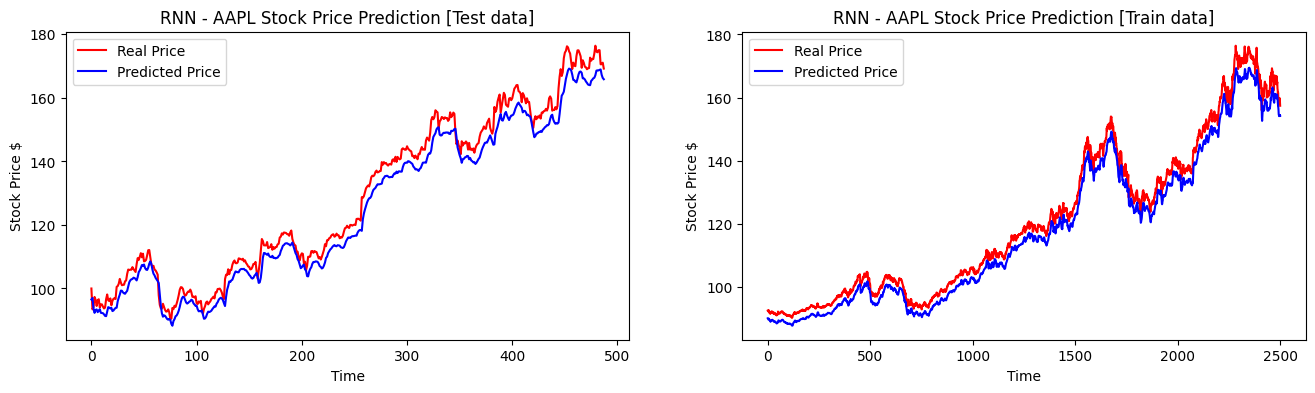

In [40]:
# Train and Validate RNN
model = RNN_model
rnn_train_loss, rnn_test_loss = [], []
for i in range(max_steps):
  rnn_train_loss.append(train_test('Train', model, device, Xtr, Ytr, lr_rate=lr_rate))
  rnn_test_loss.append(train_test('Test', model, device, Xte, Yte))
  #if i % 100 == 0:
print(f'epoch: {i+1} Train Loss: {rnn_train_loss[i]} Test Loss: {rnn_test_loss[i]}')

train_rmse, Ytr_inv, Ytr_p_inv, test_rmse, Yte_inv, Yte_p_inv = rmse_score(model, Xtr, Ytr, Xte, Yte)
print('Train RMSE Score: %.2f ' % (train_rmse))
print(' Test RMSE Score: %.2f ' % (test_rmse))
plot_pred('RNN', Yte_inv, Yte_p_inv, Ytr_inv, Ytr_p_inv)

epoch: 2000 Train Loss: 0.0007174350903369486 Test Loss: 0.00297917565330863
Train RMSE Score: 1.76 
 Test RMSE Score: 2.20 


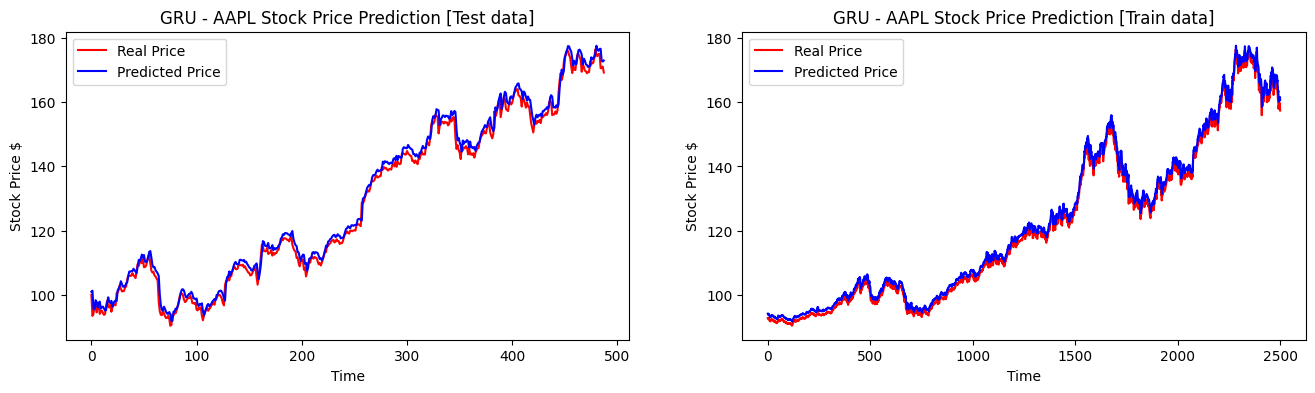

In [41]:
# Train and Validate GRU
model = GRU_model
gru_train_loss, gru_test_loss = [], []
for i in range(max_steps):
  gru_train_loss.append(train_test('Train', model, device, Xtr, Ytr, lr_rate=lr_rate))
  gru_test_loss.append(train_test('Test', model, device, Xte, Yte))
  #if i % 100 == 0:
print(f'epoch: {i+1} Train Loss: {gru_train_loss[i]} Test Loss: {gru_test_loss[i]}')

train_rmse, Ytr_inv, Ytr_p_inv, test_rmse, Yte_inv, Yte_p_inv = rmse_score(model, Xtr, Ytr, Xte, Yte)
print('Train RMSE Score: %.2f ' % (train_rmse))
print(' Test RMSE Score: %.2f ' % (test_rmse))
plot_pred('GRU', Yte_inv, Yte_p_inv, Ytr_inv, Ytr_p_inv)

In [42]:
# Train and Validate LSTM
model = LSTM_model
lstm_train_loss, lstm_test_loss = [], []
for i in range(max_steps):
  lstm_train_loss.append(train_test('Train', model, device, Xtr, Ytr, lr_rate=lr_rate))
  lstm_test_loss.append(train_test('Test', model, device, Xte, Yte))
  #if i % 100 == 0:
print(f'epoch: {i+1} Train Loss: {lstm_train_loss[i]} Test Loss: {lstm_test_loss[i]}')

train_rmse, Ytr_inv, Ytr_p_inv, test_rmse, Yte_inv, Yte_p_inv = rmse_score(model, Xtr, Ytr, Xte, Yte)
print('Train RMSE Score: %.2f ' % (train_rmse))
print(' Test RMSE Score: %.2f ' % (test_rmse))
plot_pred('LSTM', Yte_inv, Yte_p_inv, Ytr_inv, Ytr_p_inv)

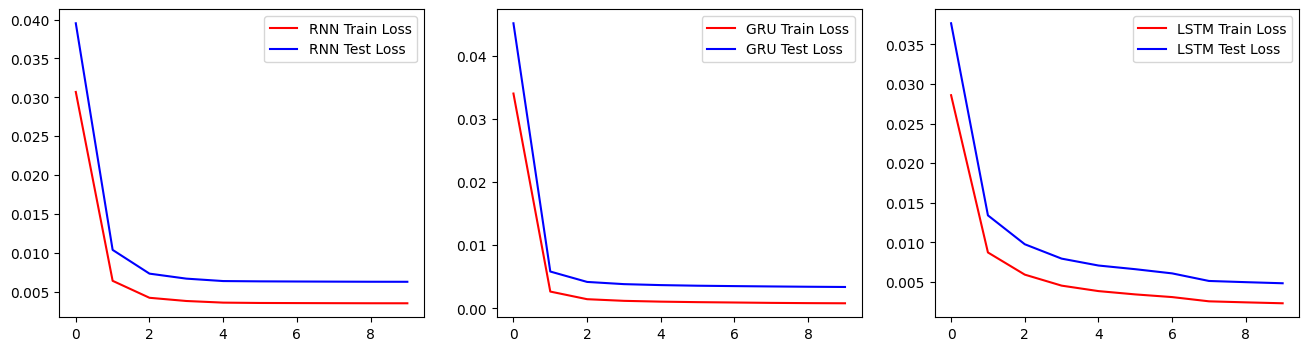

In [ ]:
# Plot all losses from three different models
plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(torch.tensor(rnn_train_loss).view(-1,200).mean(dim=1), color='red',label='RNN Train Loss')
plt.plot(torch.tensor(rnn_test_loss).view(-1,200).mean(dim=1), color='blue',label='RNN Test Loss')
plt.legend();
plt.subplot(1,3,2)
plt.plot(torch.tensor(gru_train_loss).view(-1,200).mean(dim=1), color='red',label='GRU Train Loss')
plt.plot(torch.tensor(gru_test_loss).view(-1,200).mean(dim=1), color='blue',label='GRU Test Loss')
plt.legend();
plt.subplot(1,3,3)
plt.plot(torch.tensor(lstm_train_loss).view(-1,200).mean(dim=1), color='red',label='LSTM Train Loss')
plt.plot(torch.tensor(lstm_test_loss).view(-1,200).mean(dim=1), color='blue',label='LSTM Test Loss')
plt.legend();